## This notebook is for doing [dogs and cats challenge](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

print(torch.__version__)
plt.ion()   # interactive mode

1.3.1


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        #transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'chest_xray'
CHECK_POINT_PATH = 'checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['NORMAL', 'PNEUMONIA']
Train image size: 5216
Validation image size: 624


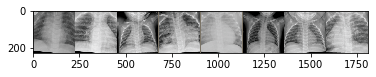

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=classes)


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [5]:
model_conv = torchvision.models.resnet50(pretrained=True)
#model_conv = torchvision.models.wide_resnet50_2(pretrained=True)
#model_conv = models.resnext50_32x4d(pretrained=True)

In [6]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 5,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.23933436148441756, Val accuracy: 0.9038461538461539
Epoch 0/9
----------
[1, 199] loss: 0.143
[1, 399] loss: 0.141
[1, 599] loss: 0.147
train Loss: 0.1443 Acc: 0.9421
val Loss: 0.2434 Acc: 0.9071

Epoch 1/9
----------
[2, 199] loss: 0.155
[2, 399] loss: 0.144
[2, 599] loss: 0.144
train Loss: 0.1424 Acc: 0.9446
val Loss: 0.2680 Acc: 0.8958

Epoch 2/9
----------
[3, 199] loss: 0.139
[3, 399] loss: 0.154
[3, 599] loss: 0.155
train Loss: 0.1550 Acc: 0.9383
val Loss: 0.2402 Acc: 0.9054

Epoch 3/9
----------
[4, 199] loss: 0.148
[4, 399] loss: 0.147
[4, 599] loss: 0.141
train Loss: 0.1413 Acc: 0.9469
val Loss: 0.3320 Acc: 0.8766

Epoch 4/9
----------
[5, 199] loss: 0.158
[5, 399] loss: 0.149
[5, 599] loss: 0.155
train Loss: 0.1566 Acc: 0.9379
val Loss: 0.2381 Acc: 0.9022
New best model found!
New record loss: 0.2380534421939116, previous record loss: 0.23933436148441756

Epoch 5/9
----------
[6, 199] loss: 0.138
[6, 399] loss: 0.139
[6, 599] loss: 0.140
train Lo